In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

In [80]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
df_data= pd.concat([train_data, test_data], ignore_index=True)

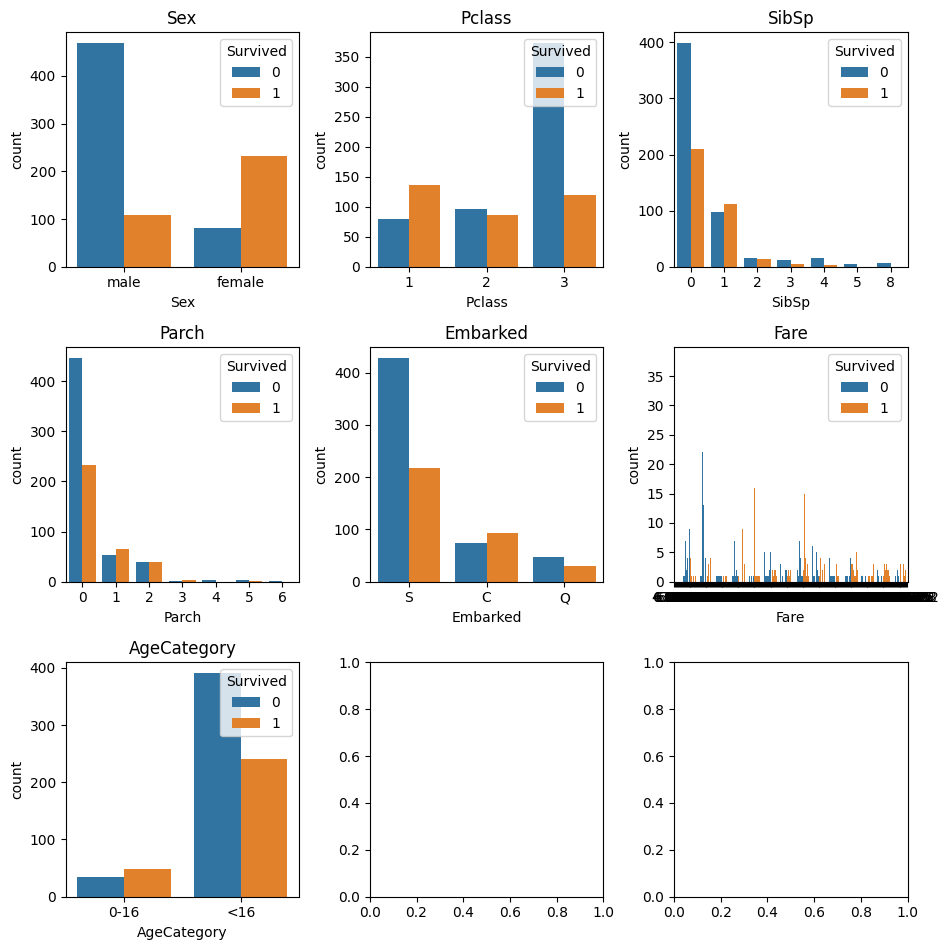

In [81]:
bins = [0, 16, float('inf')]
labels = ['0-16', '<16']
train_data['AgeCategory'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)

# Update the features list to include the new AgeCategory
features = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Fare', 'AgeCategory']

rows = 3
cols = 3

# The subplot grid and figure size of each graph
fig, axs = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.2))

for r in range(0, rows):
    for c in range(0, cols):
        i = r * cols + c  # index to go through the number of features
        if i < len(features):
            ax = axs[r][c]  # position for each subplot
            sns.countplot(data=train_data, x=features[i], hue='Survived', ax=ax)
            ax.set_title(features[i])
            ax.legend(title='Survived', loc='upper right')

plt.tight_layout()
plt.show()

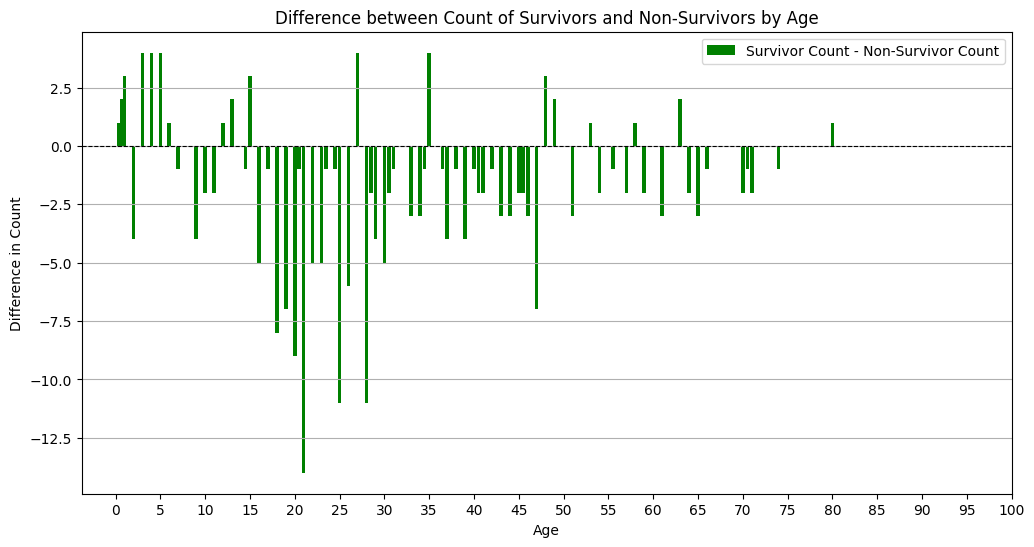

In [86]:
# Calculate count of survivors and non-survivors by age
age_survivor_count = train_data[train_data['Survived'] == 1].groupby('Age')['Survived'].count().reset_index()
age_survivor_count.columns = ['Age', 'SurvivorCount']

age_non_survivor_count = train_data[train_data['Survived'] == 0].groupby('Age')['Survived'].count().reset_index()
age_non_survivor_count.columns = ['Age', 'NonSurvivorCount']

# Merge both counts into a single DataFrame
age_counts = pd.merge(age_survivor_count, age_non_survivor_count, on='Age', how='outer').fillna(0)

# Calculate the difference between survivors and non-survivors
age_counts['Difference'] = age_counts['SurvivorCount'] - age_counts['NonSurvivorCount']

# Plotting
plt.figure(figsize=(12, 6))
bar_width = 0.4  # Width of the bars
x = age_counts['Age']  # X positions for bars

# Create a bar plot for the difference
plt.bar(x, age_counts['Difference'], width=bar_width, color='green', label='Survivor Count - Non-Survivor Count')

# Add titles and labels
plt.title('Difference between Count of Survivors and Non-Survivors by Age')
plt.xlabel('Age')
plt.ylabel('Difference in Count')
plt.xticks(range(0, 101, 5))  # Set x-ticks from 0 to 100 with a step of 5
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Line at y=0 for reference
plt.grid(axis='y')  # Add gridlines for the y-axis
plt.legend()
plt.show()

In [61]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
AgeCategory    177
dtype: int64

In [62]:
test_data.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [63]:
train_data['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [88]:
titles_to_exclude = ['Mlle', 'Mrs', 'Mme', 'Miss', 'Mr', 'Lady','Master','Ms']

# Use .str.contains() with a regex pattern to filter out names containing any of these titles
filtered_names = train_data[~train_data['Name'].str.contains(r'\b(?:' + '|'.join(titles_to_exclude) + r')\b')]

# Print the filtered names
print(filtered_names['Name'])

30                              Uruchurtu, Don. Manuel E
149                    Byles, Rev. Thomas Roussel Davids
150                           Bateman, Rev. Robert James
245                          Minahan, Dr. William Edward
249                        Carter, Rev. Ernest Courtenay
317                                 Moraweck, Dr. Ernest
398                                     Pain, Dr. Alfred
449                       Peuchen, Major. Arthur Godfrey
536                    Butt, Major. Archibald Willingham
626                       Kirkland, Rev. Charles Leonard
632                            Stahelin-Maeglin, Dr. Max
647                  Simonius-Blumer, Col. Oberst Alfons
660                        Frauenthal, Dr. Henry William
694                                      Weir, Col. John
745                         Crosby, Capt. Edward Gifford
759    Rothes, the Countess. of (Lucy Noel Martha Dye...
766                            Brewe, Dr. Arthur Jackson
796                          Le

In [89]:
# Step 1: Extract title from the Name column using regex
df_data['Title'] = df_data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Step 2: Define title replacements for rare titles and common title groups
title_replacements = {
    'Capt': 'Rare', 'Col': 'Rare', 'Countess': 'Rare', 'Don': 'Rare', 
    'Dr': 'Rare', 'Dona': 'Rare', 'Jonkheer': 'Rare', 'Major': 'Rare', 
    'Rev': 'Rare', 'Sir': 'Rare', 'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Miss', 
    'Lady': 'Mrs'
}

# Step 3: Apply the replacements using .replace()
df_data['Title'] = df_data['Title'].replace(title_replacements)

# Step 4: Map titles to numerical values for easier processing
title_mapping = {"Mr": 0, "Rare": 1, "Master": 2, "Miss": 3, "Mrs": 4}
df_data['Title'] = df_data['Title'].map(title_mapping)

# Step 5: Calculate the median age for each title group
median_age_by_title = df_data.groupby('Title')['Age'].median()

# Output the result
median_age_by_title


Title
0    29.0
1    47.0
2     4.0
3    22.0
4    36.0
Name: Age, dtype: float64

In [90]:
Ti_pred = df_data.groupby('Title')['Age'].median().values

df_data['New_Age'] = df_data['Age']

for i in range(5):  # Loop through the title indices 0 to 4
    df_data.loc[(df_data['Age'].isnull()) & (df_data['Title'] == i), 'New_Age'] = Ti_pred[i]


df_data['New_Age'] = df_data['New_Age'].astype(int)
df_data['AGE'] = (df_data['New_Age'] < 16).astype(int)


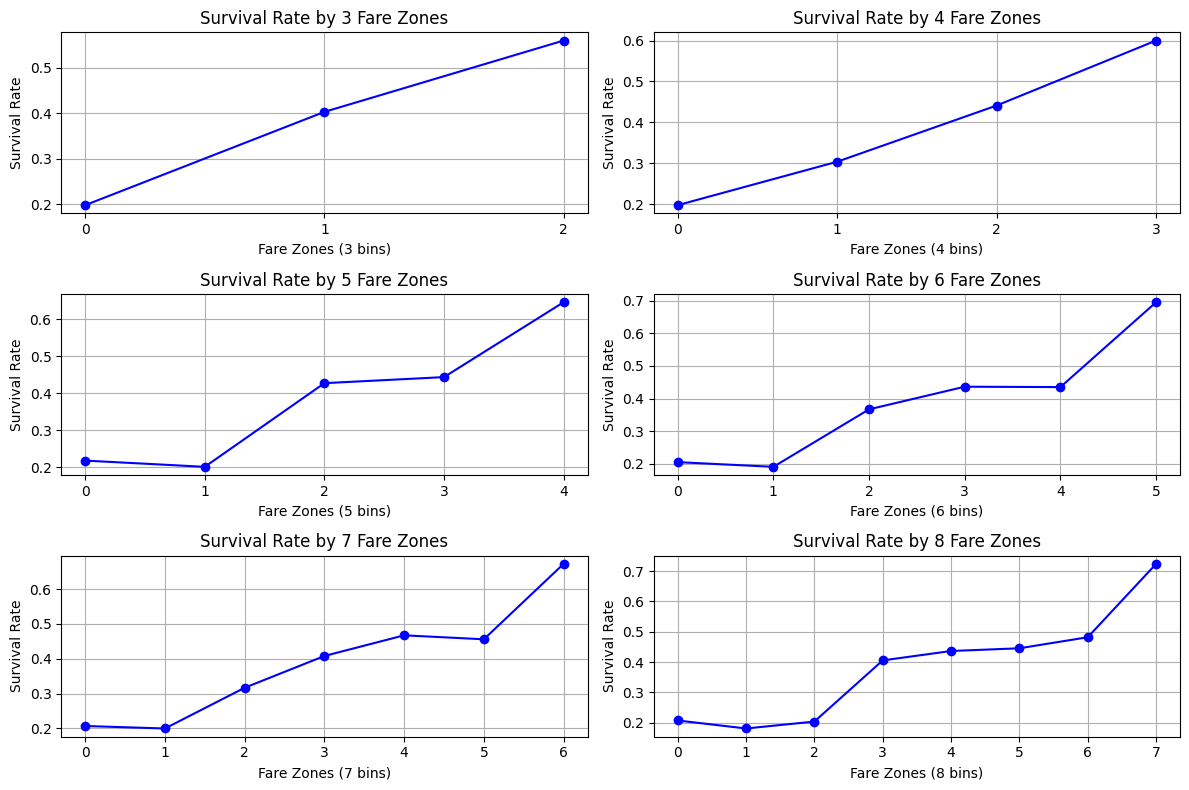

In [67]:
num_zones = [3, 4, 5, 6, 7, 8]
df_data['Fare'] = df_data['Fare'].fillna(df_data['Fare'].median())
# Create a figure for the plots
plt.figure(figsize=(12, 8))

# Loop through the number of zones and plot each
for i, zones in enumerate(num_zones, 1):
    # Step 1: Cut the 'Fare' column into different bins (zones)
    df_data[f'Fare_Bin_{zones}'] = pd.qcut(df_data['Fare'], zones, labels=False)
    
    # Step 2: Group by the binned Fare column and calculate survival rate
    survival_rate_by_fare = df_data.groupby(f'Fare_Bin_{zones}')['Survived'].mean()
    
    # Step 3: Create a subplot for each number of zones
    plt.subplot(3, 2, i)
    plt.plot(survival_rate_by_fare.index, survival_rate_by_fare.values, marker='o', linestyle='-', color='b')
    
    # Adding labels and title for each subplot
    plt.xlabel(f'Fare Zones ({zones} bins)')
    plt.ylabel('Survival Rate')
    plt.title(f'Survival Rate by {zones} Fare Zones')
    plt.xticks(survival_rate_by_fare.index)
    plt.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plots
plt.show()

In [68]:
# Filling missing values
# Making Bins
df_data['FareBin_3'] = pd.qcut(df_data['Fare'], 3)
df_data['FareBin_4'] = pd.qcut(df_data['Fare'], 4)
df_data['FareBin_5'] = pd.qcut(df_data['Fare'], 5)
df_data['FareBin_6'] = pd.qcut(df_data['Fare'], 6)
df_data['FareBin_7'] = pd.qcut(df_data['Fare'], 7)
df_data['FareBin_8'] = pd.qcut(df_data['Fare'], 8)

label = LabelEncoder()
df_data['FareBin_Code_3'] = label.fit_transform(df_data['FareBin_3'])
df_data['FareBin_Code_4'] = label.fit_transform(df_data['FareBin_4'])
df_data['FareBin_Code_5'] = label.fit_transform(df_data['FareBin_5'])
df_data['FareBin_Code_6'] = label.fit_transform(df_data['FareBin_6'])
df_data['FareBin_Code_7'] = label.fit_transform(df_data['FareBin_7'])
df_data['FareBin_Code_8'] = label.fit_transform(df_data['FareBin_8'])

In [69]:
# Calculate Family Size
df_data['FamilySize'] = df_data['SibSp'] + df_data['Parch'] + 1

# Identify duplicate tickets
duplicate_ticket_info = []

for ticket in df_data['Ticket'].unique():
    fare_group = df_data.loc[df_data['Ticket'] == ticket, 'Fare']
    
    if fare_group.count() > 1:
        duplicate_ticket_info.append(df_data.loc[df_data['Ticket'] == ticket, 
                                                  ['Name', 'Ticket', 'Fare', 'Cabin', 'FamilySize', 'Survived']])

# Concatenate information about duplicate tickets
duplicate_tickets = pd.concat(duplicate_ticket_info)

# Initialize Connected Survival
df_data['Connected_Survival'] = 0.5  # Default value

# Update Connected Survival based on ticket groupings
for _, group in df_data.groupby('Ticket'):
    if len(group) > 1:
        for index, row in group.iterrows():
            max_survival = group.drop(index)['Survived'].max()
            min_survival = group.drop(index)['Survived'].min()
            passenger_id = row['PassengerId']

            if max_survival == 1.0:
                df_data.loc[df_data['PassengerId'] == passenger_id, 'Connected_Survival'] = 1
            elif min_survival == 0.0:
                df_data.loc[df_data['PassengerId'] == passenger_id, 'Connected_Survival'] = 0

# Print summary of findings
print(f'People with the same ticket: {len(duplicate_tickets)}')
print(f"People with connected information: {df_data[df_data['Connected_Survival'] != 0.5].shape[0]}")

# Show mean survival rates based on Connected Survival
survival_rates = df_data.groupby('Connected_Survival')['Survived'].mean().round(3)
print(survival_rates)


People with the same ticket: 596
People with connected information: 496
Connected_Survival
0.0    0.225
0.5    0.298
1.0    0.728
Name: Survived, dtype: float64


In [70]:
train_data = df_data[:len(train_data)]
test_data = df_data[len(train_data):]

In [71]:
# Drop the columns
train_data = train_data.drop(['Cabin','Name','PassengerId','Ticket','Age'], axis=1)
# Remove the rows with missing values
train_data = train_data.dropna(subset =  ['Embarked'])

In [72]:
test_data = test_data.drop(['Cabin','Name','Ticket','Age','Survived'], axis=1)

In [73]:
labelencoder = LabelEncoder()

# Encode the sex column
train_data.iloc[:, 2] = labelencoder.fit_transform(train_data.iloc[:, 2].values)
test_data.iloc[:, 2] = labelencoder.fit_transform(test_data.iloc[:, 2].values)

# Encode the embarked column
train_data.iloc[:, 6] = labelencoder.fit_transform(train_data.iloc[:, 6].values)
test_data.iloc[:, 6] = labelencoder.fit_transform(test_data.iloc[:, 6].values)

In [74]:
train_data.isna().sum()

Survived              0
Pclass                0
Sex                   0
SibSp                 0
Parch                 0
Fare                  0
Embarked              0
Title                 0
New_Age               0
AGE                   0
Fare_Bin_3            0
Fare_Bin_4            0
Fare_Bin_5            0
Fare_Bin_6            0
Fare_Bin_7            0
Fare_Bin_8            0
FareBin_3             0
FareBin_4             0
FareBin_5             0
FareBin_6             0
FareBin_7             0
FareBin_8             0
FareBin_Code_3        0
FareBin_Code_4        0
FareBin_Code_5        0
FareBin_Code_6        0
FareBin_Code_7        0
FareBin_Code_8        0
FamilySize            0
Connected_Survival    0
dtype: int64

In [75]:
test_data.isna().sum()

PassengerId           0
Pclass                0
Sex                   0
SibSp                 0
Parch                 0
Fare                  0
Embarked              0
Title                 0
New_Age               0
AGE                   0
Fare_Bin_3            0
Fare_Bin_4            0
Fare_Bin_5            0
Fare_Bin_6            0
Fare_Bin_7            0
Fare_Bin_8            0
FareBin_3             0
FareBin_4             0
FareBin_5             0
FareBin_6             0
FareBin_7             0
FareBin_8             0
FareBin_Code_3        0
FareBin_Code_4        0
FareBin_Code_5        0
FareBin_Code_6        0
FareBin_Code_7        0
FareBin_Code_8        0
FamilySize            0
Connected_Survival    0
dtype: int64

In [78]:
y = train_data.iloc[:, 0].values
# Define feature sets for different models
b3 = ['Sex', 'Pclass', 'FareBin_Code_3', 'AGE', 'Connected_Survival']
b4 = ['Sex', 'Pclass', 'FareBin_Code_4', 'AGE', 'Connected_Survival']
b5 = ['Sex', 'Pclass', 'FareBin_Code_5', 'AGE', 'Connected_Survival']
b6 = ['Sex', 'Pclass', 'FareBin_Code_6', 'AGE', 'Connected_Survival']
b7 = ['Sex', 'Pclass', 'FareBin_Code_7', 'AGE', 'Connected_Survival']  # Define b7 features
b8 = ['Sex', 'Pclass', 'FareBin_Code_8', 'AGE', 'Connected_Survival']  # Define b8 features

# Initialize and fit Random Forest models
b3_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b3_Model.fit(train_data[b3], y)

b4_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b4_Model.fit(train_data[b4], y)

b5_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b5_Model.fit(train_data[b5], y)

b6_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b6_Model.fit(train_data[b6], y)

b7_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b7_Model.fit(train_data[b7], y)

b8_Model = RandomForestClassifier(random_state=2, n_estimators=250, min_samples_split=20, oob_score=True)
b8_Model.fit(train_data[b8], y)

# Print out-of-bag scores
print('b3 oob score : %.5f' % (b3_Model.oob_score_))
print('b4 oob score : %.5f' % (b4_Model.oob_score_))
print('b5 oob score : %.5f' % (b5_Model.oob_score_))
print('b6 oob score : %.5f' % (b6_Model.oob_score_))
print('b7 oob score : %.5f' % (b7_Model.oob_score_))
print('b8 oob score : %.5f' % (b8_Model.oob_score_))


b3 oob score : 0.84589
b4 oob score : 0.84364
b5 oob score : 0.84477
b6 oob score : 0.84364
b7 oob score : 0.84477
b8 oob score : 0.83802


In [57]:
# submits
X_Submit = test_data.drop(labels=['PassengerId'],axis=1)

b5_pred = b5_Model.predict(X_Submit[b5])

submit = pd.DataFrame({"PassengerId": test_data['PassengerId'],
                      "Survived":b5_pred.astype(int)})
submit.to_csv("gender_submission.csv",index=False)